# DC1 Liz Baldo

Predict when employees are going to quit by understanding the main drivers of employee churn


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-transformation-and-preprocessing" data-toc-modified-id="Data-transformation-and-preprocessing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data transformation and preprocessing</a></span><ul class="toc-item"><li><span><a href="#EDA" data-toc-modified-id="EDA-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>EDA</a></span><ul class="toc-item"><li><span><a href="#Extract-churns-from-the-data-available" data-toc-modified-id="Extract-churns-from-the-data-available-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Extract churns from the data available</a></span></li><li><span><a href="#Distribution-of-the-potential-drivers-of-churn" data-toc-modified-id="Distribution-of-the-potential-drivers-of-churn-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Distribution of the potential drivers of churn</a></span></li><li><span><a href="#Employee-headcount-over-time" data-toc-modified-id="Employee-headcount-over-time-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Employee headcount over time</a></span></li></ul></li><li><span><a href="#Feature-identification" data-toc-modified-id="Feature-identification-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Feature identification</a></span></li></ul></li><li><span><a href="#Predicting-churn" data-toc-modified-id="Predicting-churn-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Predicting churn</a></span><ul class="toc-item"><li><span><a href="#Chosing-the-model:-why-random-forest?" data-toc-modified-id="Chosing-the-model:-why-random-forest?-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Chosing the model: why random forest?</a></span></li><li><span><a href="#Validation" data-toc-modified-id="Validation-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Validation</a></span><ul class="toc-item"><li><span><a href="#Learning-curve" data-toc-modified-id="Learning-curve-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Learning curve</a></span></li><li><span><a href="#ROC-curve" data-toc-modified-id="ROC-curve-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>ROC curve</a></span></li><li><span><a href="#Confusion-matrix" data-toc-modified-id="Confusion-matrix-2.2.3"><span class="toc-item-num">2.2.3&nbsp;&nbsp;</span>Confusion matrix</a></span></li><li><span><a href="#Precision,-recall-and-Fscore" data-toc-modified-id="Precision,-recall-and-Fscore-2.2.4"><span class="toc-item-num">2.2.4&nbsp;&nbsp;</span>Precision, recall and Fscore</a></span></li></ul></li><li><span><a href="#Feature-importance" data-toc-modified-id="Feature-importance-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Feature importance</a></span></li></ul></li><li><span><a href="#Conclusion-and-key-takeaways" data-toc-modified-id="Conclusion-and-key-takeaways-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Conclusion and key takeaways</a></span></li></ul></div>

## Data transformation and preprocessing

In [80]:
import numpy as np
import pandas as pd
import datetime
from matplotlib import pyplot as plt

# Load the dataset
data = pd.read_csv('employee_retention_data.csv')
data.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


### EDA

#### Extract churns from the data available

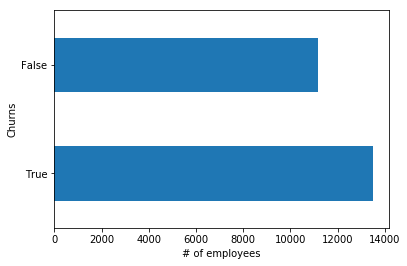

In [81]:
# Understand how many companies, and department we are dealing with here:
Companies = data['company_id'].value_counts()
Departments = data['dept'].value_counts()

# Employees who did not churn have a NaN in the quit_date column
data['churn'] = ~pd.isnull(data['quit_date'])
Churns = data['churn'].value_counts()

# Plot the distribution of churn vs. no churn to see if the data is balanced:
Churns.plot(kind = "barh")
plt.xlabel('# of employees')
plt.ylabel('Churns')
plt.show()

The number of employees who churned vs, stayed looks pretty balanced! Now we have to look at how the potential drivers of churn are distributed in order to get a better sence of which ML algorithm to use later on:

#### Distribution of the potential drivers of churn

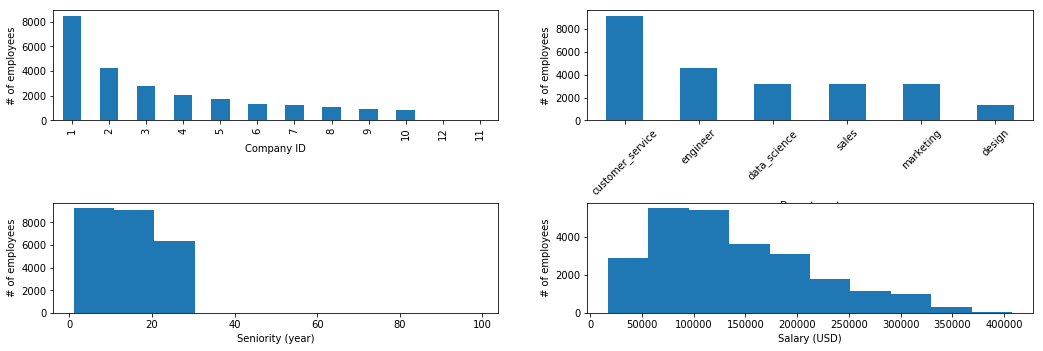

In [82]:
plt.figure(2,figsize=(16, 5))

plt.subplot(221)
Companies.plot(kind = "bar")
plt.xlabel('Company ID')
plt.ylabel('# of employees')

plt.subplot(222)
Departments.plot(kind = "bar")
plt.xlabel('Department')
plt.xticks(rotation=45)
plt.ylabel('# of employees')

plt.subplot(223)
plt.hist(data['seniority'])
plt.xlabel('Seniority (year)')
plt.ylabel('# of employees')

plt.subplot(224)
plt.hist(data['salary'])
plt.xlabel('Salary (USD)')
plt.ylabel('# of employees')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.75,
                    wspace=0.2)
plt.show()

The twelve companies significantly vary in size, with company 1 having twice as many employees as company 2, and three times as many as company 3. Companies 4 - 10 are similar in size (~ 1000 - 2000 employees), while companies 11 and 12 only have a few dozens employees.

Regarding departments, customer service and design represent the extremes, with ~9000 and ~2000 employees respectively, but the imbalance is nowhere near as pronounced as for the companies.

The salary distribution looks Gaussian, entered around ~ 100k. 

It looks like we have a few outliers in the "Seniority" variable, with a maximum of 99 years! This is either an error, or an employee who really liked his/her job. Either way it won't help with identifying drivers of churn, and will not play well with models such as logistic regression. We should probably remove data points where the seniority is larger than ~ 50 years.

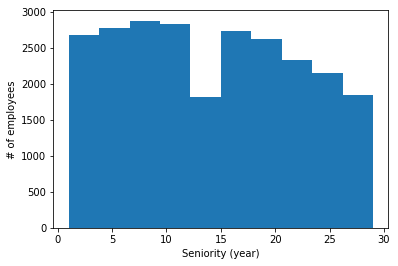

In [83]:
data = data[data['seniority'] < 50]
plt.hist(data['seniority'])
plt.xlabel('Seniority (year)')
plt.ylabel('# of employees')

plt.show()

The distribution looks better without the few outliers, and we can now include seniority as a feature in the model. 

#### Employee headcount over time

In [36]:
# Estimate employee headcount for each company on each day between 2011/01/23 and 2015/12/13:

start = datetime.datetime.strptime("2011/01/23", "%Y/%m/%d")
end = datetime.datetime.strptime("2015/12/13", "%Y/%m/%d")
day = [start + datetime.timedelta(days=x) for x in range(0, (end-start).days)]
employee_headcount = pd.DataFrame()
employee_headcount['day']=day
for c in Companies.index:
    dummy =[]
    tmp = data[(data['company_id']==c)]
    for d in range(len(day)):
        dummy.append(sum(((pd.to_datetime(tmp['join_date']) < day[d]) & ((pd.to_datetime(tmp['quit_date']) > day[d]) | pd.isnull(tmp['quit_date'])))))
        
    employee_headcount[c]=dummy

1
2
3
4
5
6
7
8
9
10
12
11


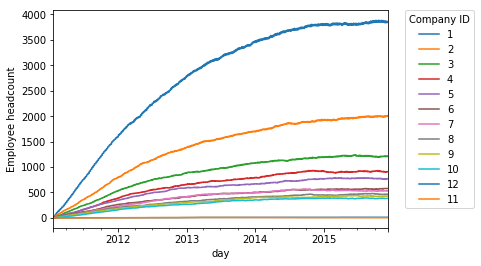

In [43]:
# Plot the headcount over time for each company
employee_headcount.plot(x=employee_headcount['day'])
plt.ylabel('Employee headcount')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Company ID')

plt.show()

This further confirms the class imbalance nature of the company ID. All the companies but 11 nad 12 were able to grow over the first three years, and then plateau with the hiring and churn rates balancing each other. Companies 11 and 12 however were unable to scale and consistently kept a very low headcount of a few employees.

### Feature identification

Before going down the ML route, let's try to quickly get a better sense of the drivers of churn by looking one more time at the data.
Below we calculate and plot the churn rate for each company, department, seniority (binned in 5 years increments), and salary (binned in 50k increments):

In [84]:
## Look at churn vs. company, dept, seniority and salary

churn_company = []
for c in Companies.index:   
    tmp = data[(data['company_id']==c)]
    churn_company.append(sum(tmp['churn']==True)/(sum(tmp['churn']==True)+sum(tmp['churn']==False)))

churn_dept = []
for c in Departments.index:
    tmp = data[(data['dept']==c)]
    churn_dept.append(sum(tmp['churn']==True)/(sum(tmp['churn']==True)+sum(tmp['churn']==False)))

seniority_bin = [0,5,10,15,20,25]
churn_seniority =  []
for i in range(len(seniority_bin)):
    if i < len(seniority_bin)-1:
        tmp = data[(data['seniority']>seniority_bin[i]) & (data['seniority']<seniority_bin[i+1])]
    else:
        tmp = data[(data['seniority']>seniority_bin[i])]
        
    churn_seniority.append(sum(tmp['churn']==True)/(sum(tmp['churn']==True)+sum(tmp['churn']==False)))

salary_bin = [0,50,100,150,200,250]
churn_salary =  []
for i in range(len(salary_bin)):
    if i < len(salary_bin)-1:
        tmp = data[(data['salary']>salary_bin[i]*1000) & (data['salary']<salary_bin[i+1]*1000)]
    else:
        tmp = data[(data['salary']>salary_bin[i]*1000)]
        
    churn_salary.append(sum(tmp['churn']==True)/(sum(tmp['churn']==True)+sum(tmp['churn']==False)))
    

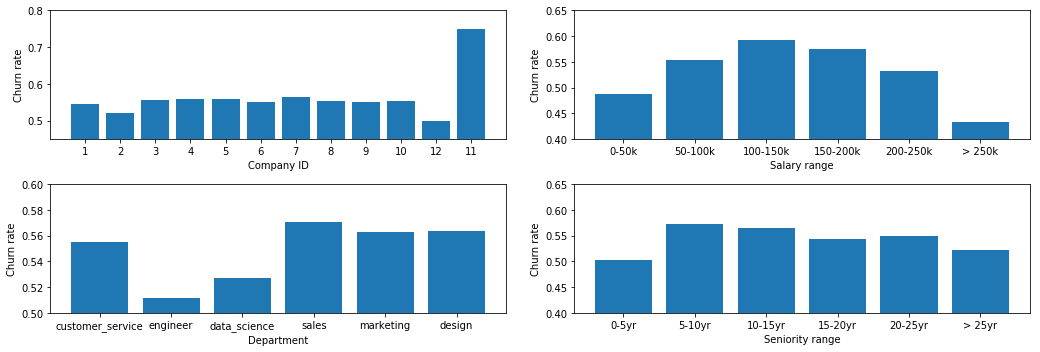

In [85]:
plt.figure(2,figsize=(16, 5))

plt.subplot(221)
plt.bar(np.arange(12),churn_company)
plt.xlabel('Company ID')
plt.xticks(np.arange(12), Companies.index )
plt.ylabel('Churn rate')
plt.ylim((0.45,0.8))

plt.subplot(223)
plt.bar(np.arange(6),churn_dept)
plt.xlabel('Department')
plt.xticks(np.arange(6), Departments.index )
plt.ylabel('Churn rate')
plt.ylim((0.5,0.6))

plt.subplot(222)
plt.bar(np.arange(6),churn_salary)
plt.xlabel('Salary range')
plt.xticks( np.arange(6), ('0-50k', '50-100k', '100-150k', '150-200k', '200-250k','> 250k') )
plt.ylabel('Churn rate')
plt.ylim((0.4,0.65))

plt.subplot(224)
plt.bar(np.arange(6),churn_seniority)
plt.xlabel('Seniority range')
plt.xticks( np.arange(6), ('0-5yr', '5-10yr', '10-15yr', '15-20yr', '20-25yr','> 25yr') )
plt.ylabel('Churn rate')
plt.ylim((0.4,0.65))

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.35,
                    wspace=0.15)

plt.show()


We can already extract a few interesting insights here. The first thing is that company 11 is not doing a good job at keeping its employees, and shows a churn rate of 75%! The other companies are performing similary with churn rates around 50%.

Regarding departments, client facing jobs such as sales, customer service, marketing and design have the highest churn rates (55 - 57%), while engineering and data science have the lowest (51 - 53 %).

The impact of salary on churn rate is interesting, with the extreme low / high salary ranges having the lowest churn rates (below 50%), and the 100-150k range having the largest (almost 60%). 

Finally, besides the low churn rate observed for relatively junior employees (less than 5 years of experience) seniority does not seem to impact churn rate as much.

## Predicting churn

### Chosing the model: why random forest?

We have categorical data, and we we need a model that yields feature importance in order to identify drivers of churn. Random forest therefore seems to be a good candidate.


In [142]:
# Prepare data for random forest
Y = data['churn']
X = pd.concat([data['company_id'],data['dept'],data['seniority'],data['salary']], axis=1)

# Remove string and replace by number ID for the dept feature:
for i in range(len(Departments.index)):
    X['dept'] = X['dept'].replace(Departments.index[i], i)
X.head()

,company_id,dept,seniority,salary
0,7,0,28,89000.0
1,7,4,20,183000.0
2,4,4,14,101000.0
3,7,0,20,115000.0
4,2,2,23,276000.0


In [197]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support,roc_curve, auc
from sklearn.cross_validation import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
 
rfc = RandomForestClassifier(n_jobs=-1, max_features='sqrt') 
 
# Use a grid over parameters of interest
param_grid = { 
           "n_estimators" : [9, 18, 27, 36, 45, 54, 63],
           "max_depth" : [1, 5, 10, 15, 20, 25, 30],
           "min_samples_leaf" : [1, 2, 4, 6, 8, 10]}

# Use a 5-fold cross validation:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X, Y)
print(CV_rfc.best_params_)

{'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 45}


Based on the grid search, we can select and train the best estimator:

In [205]:
#rfc_best = RandomForestClassifier(n_estimators=18, max_depth=5, max_features='sqrt', min_samples_leaf = 10)
rfc_best = RandomForestClassifier(n_estimators=45, max_depth=5, max_features='sqrt', min_samples_leaf = 10)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.7, random_state=42)

rfc_best.fit(X_train,y_train)
y_pred = rfc_best.predict(X_test)


### Validation
#### Learning curve

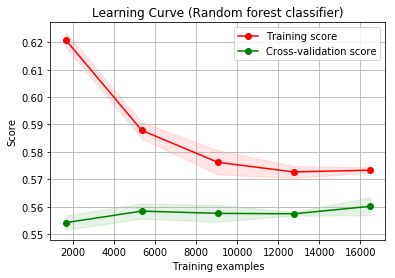

In [206]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

title = "Learning Curve (Random forest classifier)"
estimator = rfc_best
plot_learning_curve(estimator, title, X, Y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5))
plt.show()

#### ROC curve

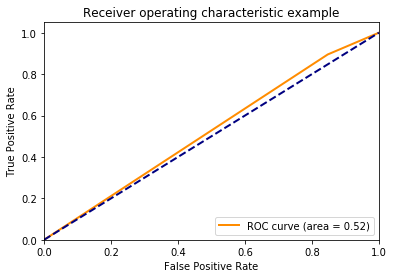

In [207]:
## ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
roc_auc

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

#### Confusion matrix

Confusion matrix, without normalization
[[1206 6687]
 [ 987 8410]]


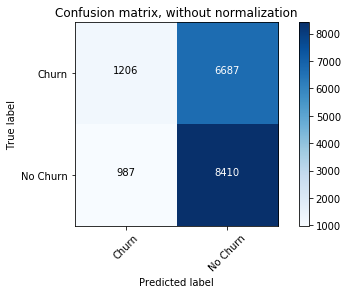

In [208]:
from sklearn.metrics import confusion_matrix
import itertools


cnf_matrix = confusion_matrix(y_test, y_pred)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Churn','No Churn'],
                      title='Confusion matrix, without normalization')    
plt.show()

#### Precision, recall and Fscore

In [209]:
from sklearn.metrics import precision_recall_fscore_support

# Take into account label inbalance:
precision_recall_fscore_support(y_test, y_pred, average='weighted')

(0.5538081847228975, 0.55615962984384038, 0.48238675901986883, None)

### Feature importance

Feature ranking:
1. feature Salary (0.542530)
2. feature Seniority (0.231709)
3. feature Department (0.120232)
4. feature Company ID (0.105530)


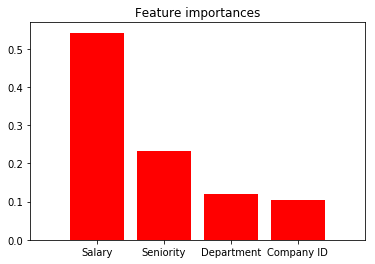

In [204]:
importances = rfc_best.feature_importances_
feature_list = ['Company ID','Department','Seniority','Salary']
print("Feature ranking:")
indices = np.argsort(importances)[::-1]
tmp_feature = []
for f in range(len(indices)):
    print("%d. feature %s (%f)" % (f + 1, feature_list[indices[f]], importances[indices[f]]))
    tmp_feature.append(feature_list[indices[f]])

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices],
       color="r", align="center")
plt.xticks(range(len(indices)), tmp_feature)
plt.xlim([-1, len(indices)])
plt.show()


## Conclusion and key takeaways

Given the need to understand feature importance, a random forest was applied to predict employee churn based on the company ID, the department, the salary and seniority.

The model performed without overfitting, and reached a precision, recall, and F1 score of 55%, 56% and 48% respectively on the testing set (using a 5 fold crosssvalidation approach).

The random forest model identified salary and seniority as the main driver of employee churn. The department or the company the employee worked did not have as big of an impact.

With more time, including the length of employment as a feature might lead to interesting insights. Further, the length of commute and ratio of salary vs. working hours might also be potential interesting drivers to investigate.

Finally, a logistic regression approach could also be investigated as an alternative to random forest. The use of Ridge regularization for instance might be useful to deal with the possible colinearities between features (e.g. seniority and salary).

In [ ]:
# Logistic regression stuff:

# from sklearn.linear_model import LogisticRegression
# from sklearn.grid_search import GridSearchCV
# from sklearn.linear_model import LogisticRegressionCV


# Prepare data for model training:
# Y = data['churn']
# X = pd.concat([pd.get_dummies(data['company_id']),pd.get_dummies(data['dept']),data['seniority'],data['salary']], axis=1)
# X.head()


# # 5-fold cross validation
# fold = KFold(len(Y), n_folds=5, shuffle=True, random_state=42)

# grid = {
#         'C': np.power(10.0, np.arange(-10, 10))
#          , 'solver': ['newton-cg']
#     }
# clf = LogisticRegression(penalty='l2', random_state=42, max_iter=10000, tol=1e-4)
# gs = GridSearchCV(clf, grid, scoring='roc_auc', cv=fold)
# gs.fit(X, Y)

# print ('Best ROC AUC score:', gs.best_score_)
# print ('Best estimator:', gs.best_estimator_)

# # Train the best model on training data 
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=42)
# model = gs.best_estimator_
# model.fit(X_train, _train)